# Analysic model with ARIMA and SARIMA
## 1.  AutoCorrelation and Partial AutoCorrelation (ACF, PACF)
## 2. Stationarity
Non-stationarity is caused by:
1. Trend
1. Seasonality 
### Augmented Dickey–Fuller test for stationarity
Link: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
### Making Time Series Stationary with Differencing
# ARIMA
### Using `auto_arima` to find the best parameters

Link to Python function: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html


The function in Python is based on the R function `auto.arima` which is better documented and explained here: https://www.rdocumentation.org/packages/forecast/versions/8.14/topics/auto.arima

In [77]:
import numpy as np
import pandas as pd
#import data
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(rc={'figure.figsize':(11.7,8.27)})
from pandas_datareader import data
import datetime
from bokeh.plotting import show, output_file
#from kora.bokeh import figure

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [117]:
!pip install yfinance
import yfinance as yf
dataGOOG = yf.download('GOOG','2014-03-27','2019-07-02')
dataGOOG.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-03-27,566.444824,566.444824,551.406128,556.930969,556.930969,13136
2014-03-28,559.663452,564.879150,557.140381,558.456787,558.456787,41213
2014-03-31,565.337891,565.447571,555.405151,555.445007,555.445007,10830
2014-04-01,557.180237,566.893616,557.180237,565.607117,565.607117,7922
2014-04-02,598.347229,603.174011,560.650757,565.447571,565.447571,147103


In [118]:
#Remove the date column
remove_list = ['High','Low','Open','Volume','High','Adj Close'] 
dataGOOG = dataGOOG.drop(columns=remove_list)
dataGOOG

,Close
Date,
2014-03-27,556.930969
2014-03-28,558.456787
2014-03-31,555.445007
2014-04-01,565.607117
2014-04-02,565.447571
...,...
2019-06-25,1086.349976
2019-06-26,1079.800049
2019-06-27,1076.010010


#1. AutoCorrelation and Partial AutoCorrelation (ACF, PACF)

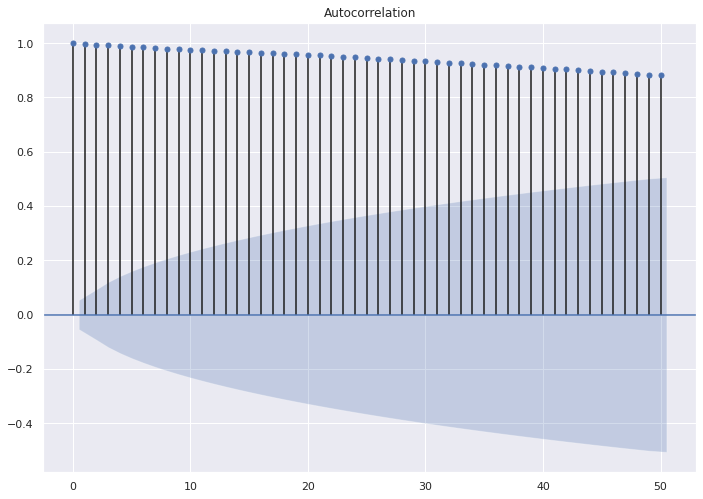

In [119]:
plt = plot_acf(dataGOOG, lags=50)
plt.show()

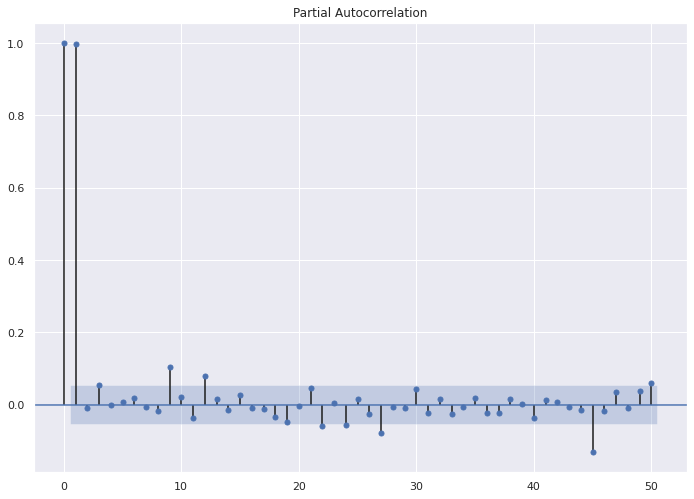

In [120]:
plt = plot_pacf(dataGOOG, lags=50)
plt.show()

## Stationarity

Non-stationarity is caused by:
1. Trend
1. Seasonality

### Augmented Dickey–Fuller test for stationarity
Link: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test

In [121]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(dataGOOG['Close'])
dftest
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -0.845669
p-value                           0.805338
#Lags Used                       11.000000
Number of Observations Used    1313.000000
Critical Value (1%)              -3.435340
Critical Value (5%)              -2.863744
Critical Value (10%)             -2.567943
dtype: float64


#### p-value> 0.05 (or 5%) --> This original time series is not stationary.

### Making Time Series Stationary with Differencing

In [122]:
# Original Series

dataGOOG.head()

,Close
Date,
2014-03-27,556.930969
2014-03-28,558.456787
2014-03-31,555.445007
2014-04-01,565.607117
2014-04-02,565.447571


In [123]:
# (First-order) Differencing

dataGOOG = dataGOOG.diff()
dataGOOG.head() 

,Close
Date,
2014-03-27,NaN
2014-03-28,1.525818
2014-03-31,-3.011780
2014-04-01,10.162109
2014-04-02,-0.159546


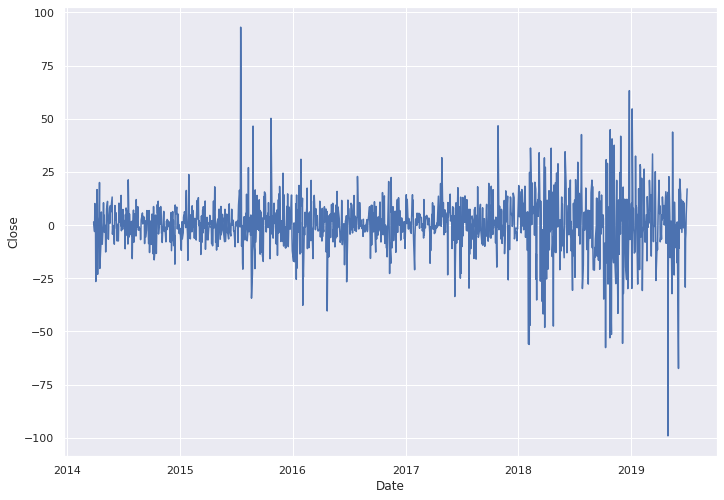

In [124]:
# Plot differenced series
sns.lineplot(data=dataGOOG, x="Date", y="Close")

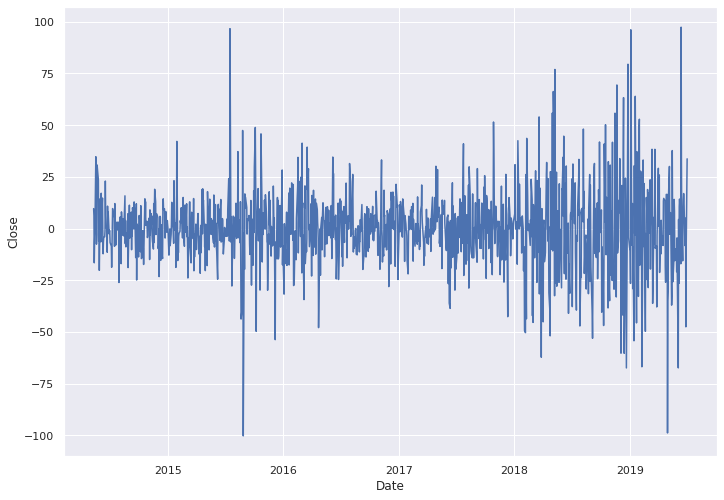

In [125]:
# Seasonal Differencing

dataGOOG = dataGOOG.diff(30)

sns.lineplot(data=dataGOOG, x="Date", y="Close")

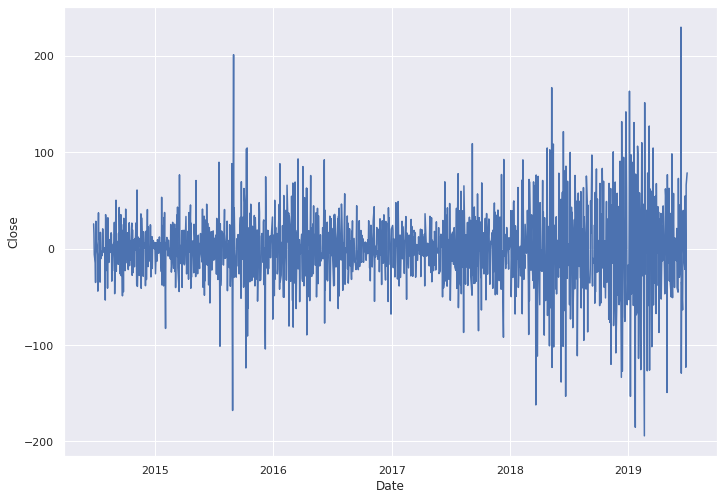

In [126]:
# Combine Normal Differencing with Seasonal Differencing

dataGOOG = dataGOOG.diff(30).diff()

sns.lineplot(data=dataGOOG, x="Date", y="Close")

In [127]:
dataGOOG.dropna(inplace=True)

In [128]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(dataGOOG['Close'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.493950e+01
p-value                        1.329132e-27
#Lags Used                     2.300000e+01
Number of Observations Used    1.239000e+03
Critical Value (1%)           -3.435639e+00
Critical Value (5%)           -2.863876e+00
Critical Value (10%)          -2.568013e+00
dtype: float64


p-value = 0 <0.05 received

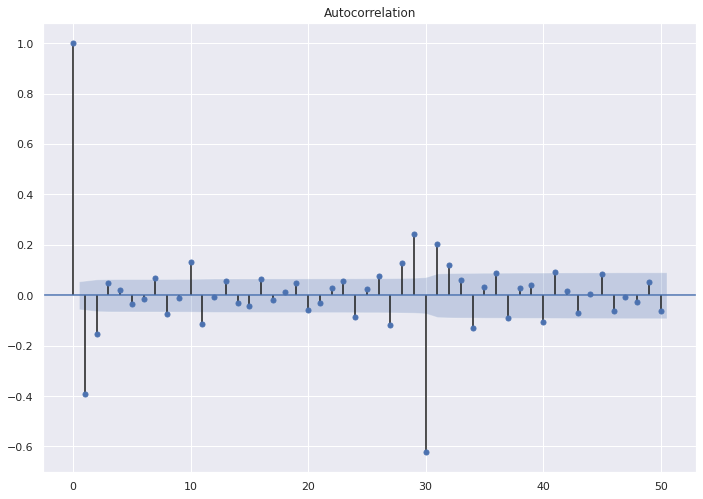

In [129]:
plt = plot_acf(dataGOOG, lags=50)
plt.show()

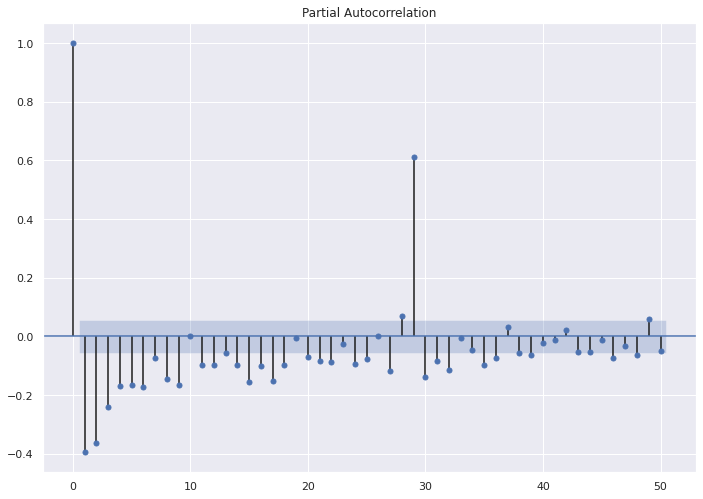

In [130]:
plt = plot_pacf(dataGOOG, lags=50)
plt.show()

## ARIMA

In [93]:
!pip install pmdarima
import pmdarima as pm

     |████████████████████████████████| 1.5MB 28.0MB/s 
     |████████████████████████████████| 9.5MB 15.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [131]:

model = pm.auto_arima(dataGOOG['Close'], ## Original Time Series
                      d=1, ## number of normal (non-seasonal) differencing
                      D=1, ## number of seasonal differencing
                      seasonal=True, 
                      m=30, ## daily data, so m = 30
                      trend='c',
                      start_p=0, 
                      start_q=0, 
                      test='adf', ## Augmented Dickey-Fuller test
                      stepwise=True, ## Method of search for the best model parameters
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[30]             : AIC=inf, Time=26.06 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=15444.227, Time=0.61 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=14015.242, Time=21.31 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=35.45 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=14948.154, Time=1.07 sec
 ARIMA(1,1,0)(2,1,0)[30]             : AIC=inf, Time=106.67 sec
 ARIMA(1,1,0)(1,1,1)[30]             : AIC=inf, Time=34.49 sec
 ARIMA(1,1,0)(0,1,1)[30]             : AIC=inf, Time=22.82 sec
 ARIMA(1,1,0)(2,1,1)[30]             : AIC=inf, Time=101.81 sec
 ARIMA(0,1,0)(1,1,0)[30]             : AIC=14595.638, Time=18.54 sec
 ARIMA(2,1,0)(1,1,0)[30]             : AIC=inf, Time=46.74 sec
 ARIMA(1,1,1)(1,1,0)[30]             : AIC=inf, Time=82.74 sec
 ARIMA(0,1,1)(1,1,0)[30]             : AIC=inf, Time=26.42 sec
 ARIMA(2,1,1)(1,1,0)[30]             : AIC=inf, Time=54.68 sec
 ARIMA(1,1,0)(1,1,0)[30] intercept   : AIC=14015.24

In [132]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1263
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 30)   Log Likelihood               -7003.621
Date:                            Sun, 04 Jul 2021   AIC                          14015.242
Time:                                    03:36:23   BIC                          14035.707
Sample:                                         0   HQIC                         14022.941
                                           - 1263                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1558      2.019      0.077      0.939      -3.802       4.114
ar.L1         -0.6143      0.018    -34.998      0.000      -0.649      -0.580
ar.S.L30      -0.7387      0.014    -52.622      0.000      -0.766      -0.711
sigma2      4976.6547    137.378     36.226      0.000    4707.399    5245.910
===================================================================================
Ljung-Box (Q):                     1235.09   Jarque-Bera (JB):               289.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.39   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build Model with optimal parameters

Reference: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [133]:
# reset data
dataGOOG = yf.download('GOOG','2014-03-27','2019-07-02')
dataGOOG.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-03-27,566.444824,566.444824,551.406128,556.930969,556.930969,13136
2014-03-28,559.663452,564.879150,557.140381,558.456787,558.456787,41213
2014-03-31,565.337891,565.447571,555.405151,555.445007,555.445007,10830
2014-04-01,557.180237,566.893616,557.180237,565.607117,565.607117,7922
2014-04-02,598.347229,603.174011,560.650757,565.447571,565.447571,147103


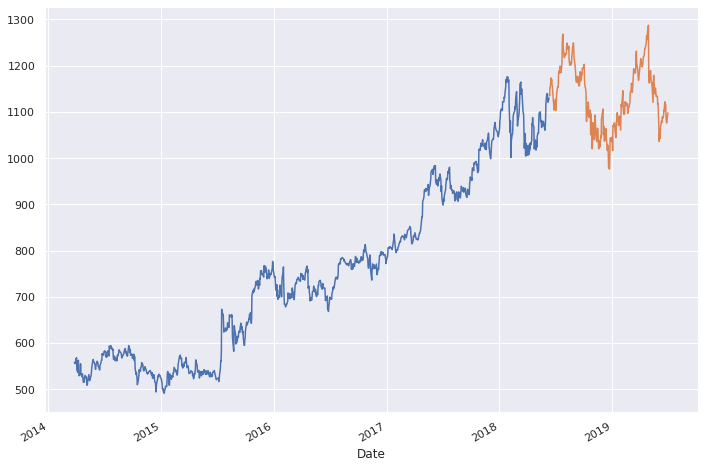

In [134]:
# Divide into train and validation set
divide = int(0.80*(len(dataGOOG)))
train = dataGOOG[:divide]
test = dataGOOG[divide:]

# Plotting the data
train['Close'].plot()
test['Close'].plot()

In [136]:
#Best model:  ARIMA(0,1,0)(1,1,0)[30] intercept
#Best model:  ARIMA(1,1,0)(1,1,0)[30] intercept
model = SARIMAX(train['Close'], 
                order=(1,1,0),
                seasonal_order=(1,1,0,30))

fitted_model = model.fit()
fitted_model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  try:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 1060
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 30)   Log Likelihood               -4109.321
Date:                            Sun, 04 Jul 2021   AIC                           8224.642
Time:                                    03:36:53   BIC                           8239.451
Sample:                                         0   HQIC                          8230.263
                                           - 1060                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0252      0.023      1.116      0.264      -0.019       0.069
ar.S.L30      -0.5271      0.018    -29.426      0.000      -0.562      -0.492
sigma2       170.6570      4.118     41.443      0.000     162.586     178.728
===================================================================================
Ljung-Box (Q):                      135.64   Jarque-Bera (JB):              1051.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Visualize predictions

Reference: https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_prediction.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_prediction

In [137]:
# Forecasting
forecast_object = fitted_model.get_forecast(steps=len(test))
mean = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()
#dates = mean.index

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  # Issue warnings for unsupported indexes


In [138]:
dff_clone = dataGOOG.copy()
dff_clone["date"] = dataGOOG.index
dff_clone

,Open,High,Low,Close,Adj Close,Volume,date
Date,,,,,,,
2014-03-27,566.444824,566.444824,551.406128,556.930969,556.930969,13136,2014-03-27
2014-03-28,559.663452,564.879150,557.140381,558.456787,558.456787,41213,2014-03-28
2014-03-31,565.337891,565.447571,555.405151,555.445007,555.445007,10830,2014-03-31
2014-04-01,557.180237,566.893616,557.180237,565.607117,565.607117,7922,2014-04-01
2014-04-02,598.347229,603.174011,560.650757,565.447571,565.447571,147103,2014-04-02
...,...,...,...,...,...,...,...
2019-06-25,1112.660034,1114.349976,1083.800049,1086.349976,1086.349976,1546900,2019-06-25
2019-06-26,1086.500000,1092.969971,1072.239990,1079.800049,1079.800049,1810900,2019-06-26
2019-06-27,1084.000000,1087.099976,1075.290039,1076.010010,1076.010010,1004300,2019-06-27


In [139]:
test_clone = test.copy()
test_clone["date"] = test.index
test_clone

,Open,High,Low,Close,Adj Close,Volume,date
Date,,,,,,,
2018-06-12,1131.069946,1139.790039,1130.734985,1139.319946,1139.319946,912000,2018-06-12
2018-06-13,1141.119995,1146.500000,1133.380005,1134.790039,1134.790039,1506400,2018-06-13
2018-06-14,1143.849976,1155.469971,1140.640015,1152.119995,1152.119995,1343400,2018-06-14
2018-06-15,1148.859985,1153.420044,1143.484985,1152.260010,1152.260010,2122500,2018-06-15
2018-06-18,1143.650024,1174.310059,1143.589966,1173.459961,1173.459961,1413700,2018-06-18
...,...,...,...,...,...,...,...
2019-06-25,1112.660034,1114.349976,1083.800049,1086.349976,1086.349976,1546900,2019-06-25
2019-06-26,1086.500000,1092.969971,1072.239990,1079.800049,1079.800049,1810900,2019-06-26
2019-06-27,1084.000000,1087.099976,1075.290039,1076.010010,1076.010010,1004300,2019-06-27


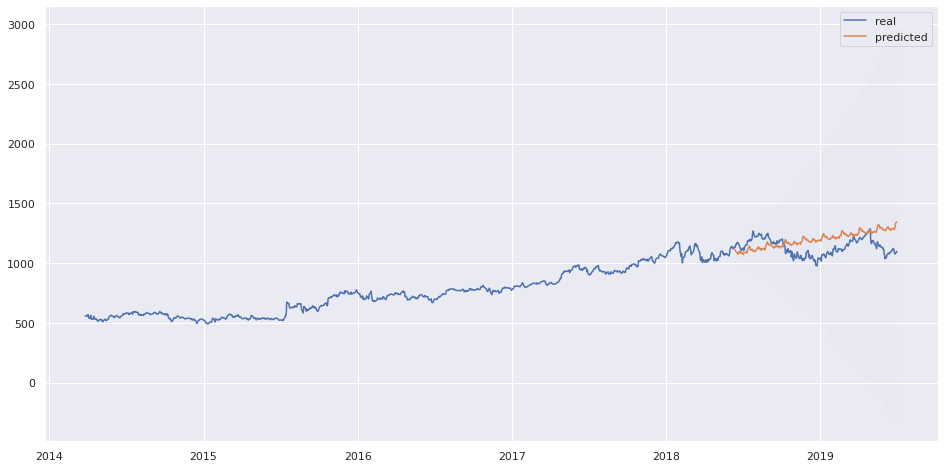

In [140]:
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
# Plot actual values
#df_thir = df_thir.index.to
#df_thir.index = pd.to_datetime(df_thir.index)
plt.plot(dff_clone.date, dff_clone.Close, label='real')

# Plot the prediction means as line
plt.plot(test_clone.date, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(test_clone.date, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.01)

# Plot legend and show figure
plt.legend()
plt.savefig('predtest')
plt.show()

### Get Predictions & Calculate Accuracy

Reference: https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.predict.html

In [146]:
#Best model:  ARIMA(1,1,0)(1,1,0)[30] intercept
start=len(train)
end=len(train)+len(test)-1

predictions = fitted_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,0)(1,1,0,30) Predictions')
# Fitting model 
# Best model:  ARIMA(0,1,0)(2,1,0)[12]  intercept

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  # Issue warnings for unsupported indexes


In [147]:
print(dataGOOG.iloc[start])
print(dataGOOG.iloc[end])

Open           1131.069946
High           1139.790039
Low            1130.734985
Close          1139.319946
Adj Close      1139.319946
Volume       912000.000000
Name: 2018-06-12 00:00:00, dtype: float64
Open         1.098000e+03
High         1.107580e+03
Low          1.093703e+03
Close        1.097950e+03
Adj Close    1.097950e+03
Volume       1.436300e+06
Name: 2019-07-01 00:00:00, dtype: float64


In [148]:
predictions_clone = test.copy()
predictions_clone['Close'] = 0
predictions_clone = predictions_clone.add(pd.Series(predictions.values, index= test_clone.date ),
       axis='index')
predictions_clone

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-12,2248.091614,2256.811707,2247.756654,1117.021668,2256.341614,9.131170e+05
2018-06-13,2248.669429,2254.049434,2240.929439,1107.549434,2242.339473,1.507508e+06
2018-06-14,2244.173098,2255.793093,2240.963137,1100.323122,2252.443117,1.344500e+06
2018-06-15,2245.270763,2249.830821,2239.895763,1096.410777,2248.670787,2.123596e+06
2018-06-18,2229.607699,2260.267733,2229.547640,1085.957674,2259.417635,1.414786e+06
...,...,...,...,...,...,...
2019-06-25,2393.460266,2395.150207,2364.600280,1280.800231,2367.150207,1.548181e+06
2019-06-26,2384.717952,2391.187922,2370.457942,1298.217952,2378.018000,1.812198e+06
2019-06-27,2392.735474,2395.835450,2384.025513,1308.735474,2384.745484,1.005609e+06


In [149]:
# Calculate Accuracy metrics
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Close'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Close'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Close'], predictions)
#test.sub(pd.Series(predictions.values, index= test_clone.date ), axis='index')
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions_clone['Close'] - test['Close'])/np.abs(test['Close']))*100 
#valuation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions.values - test['Close'])/np.abs(test['Close']))*100 
optimal_accuracy = evaluation_results.copy(deep=True)
optimal_accuracy  

,r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,-2.075474,102.200292,13664.745942,9.206664


# PREDICTION USING RANDOM FORCAST


In [52]:
#!pip install yfinance
import yfinance as yf
df_EMA = yf.download('GOOG','2014-03-27','2021-07-02')
df_EMA.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-03-27,566.444824,566.444824,551.406128,556.930969,556.930969,13136
2014-03-28,559.663452,564.879150,557.140381,558.456787,558.456787,41213
2014-03-31,565.337891,565.447571,555.405151,555.445007,555.445007,10830
2014-04-01,557.180237,566.893616,557.180237,565.607117,565.607117,7922
2014-04-02,598.347229,603.174011,560.650757,565.447571,565.447571,147103


In [54]:
#Create functions to calculate the SMA, & the EMA
#Create the Simple Moving Average Indicator
#Typical time periods for moving averages are 15, 20,& 30
#Create the Simple Moving Average Indicator
def SMA(data, period=30, column='Close'):
  return data[column].rolling(window=period).mean()
#Create the Exponential Moving Average Indicator
def EMA(data, period=20, column='Close'):
  return data[column].ewm(span=period, adjust=False).mean()

In [57]:
#Create a function to calculate the Moving Average Convergence/Divergence (MACD)
def MACD(data, period_long=26, period_short=12, period_signal=9, column='Close'):
    #Calculate the Short Term Exponential Moving Average
    ShortEMA = EMA(data, period_short, column=column) #AKA Fast moving average
    #Calculate the Long Term Exponential Moving Average
    LongEMA = EMA(data, period_long, column=column) #AKA Slow moving average
    #Calculate the Moving Average Convergence/Divergence (MACD)
    data['MACD'] = ShortEMA - LongEMA
    #Calcualte the signal line
    data['Signal_Line'] = EMA(data, period_signal, column='MACD')#data['MACD'].ewm(span=period_signal, adjust=False).mean()
    return data

In [55]:
#Create a function to calculate the Relative Strength Index (RSI)
def RSI(data, period = 14, column = 'Close'):
  delta = data[column].diff(1) #Use diff() function to find the discrete difference over the column axis with period value equal to 1
  delta = delta.dropna() # or delta[1:]
  up =  delta.copy() #Make a copy of this object’s indices and data
  down = delta.copy() #Make a copy of this object’s indices and data
  up[up < 0] = 0 
  down[down > 0] = 0 
  data['up'] = up
  data['down'] = down
  AVG_Gain = SMA(data, period, column='up')#up.rolling(window=period).mean()
  AVG_Loss = abs(SMA(data, period, column='down'))#abs(down.rolling(window=period).mean())
  RS = AVG_Gain / AVG_Loss
  RSI = 100.0 - (100.0/ (1.0 + RS))
  data['RSI'] = RSI
  return data

In [58]:
#Add the indicators to the data set
#Creating the data set 
MACD(df_EMA)
RSI(df_EMA)
df_EMA['SMA'] = SMA(df_EMA)
df_EMA['EMA'] = EMA(df_EMA)
#Show the data
df_EMA


,Open,High,Low,Close,Adj Close,Volume,MACD,Signal_Line,up,down,RSI,SMA,EMA
Date,,,,,,,,,,,,,
2014-03-27,566.444824,566.444824,551.406128,556.930969,556.930969,13136,0.000000,0.000000,NaN,NaN,NaN,NaN,556.930969
2014-03-28,559.663452,564.879150,557.140381,558.456787,558.456787,41213,0.121718,0.024344,1.525818,0.000000,NaN,NaN,557.076285
2014-03-31,565.337891,565.447571,555.405151,555.445007,555.445007,10830,-0.024563,0.014562,0.000000,-3.011780,NaN,NaN,556.920925
2014-04-01,557.180237,566.893616,557.180237,565.607117,565.607117,7922,0.671763,0.146002,10.162109,0.000000,NaN,NaN,557.748182
2014-04-02,598.347229,603.174011,560.650757,565.447571,565.447571,147103,1.196934,0.356189,0.000000,-0.159546,NaN,NaN,558.481457
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-25,2539.139893,2550.100098,2528.879883,2539.899902,2539.899902,1674200,45.126803,47.284471,0.000000,-5.739990,70.444798,2449.394336,2492.146946
2021-06-28,2540.000000,2546.739990,2519.476074,2536.389893,2536.389893,1405500,43.257796,46.479136,0.000000,-3.510010,66.004960,2456.735335,2496.360560
2021-06-29,2535.449951,2540.000000,2508.739990,2520.370117,2520.370117,1047500,40.022578,45.187824,0.000000,-16.019775,58.289995,2463.367342,2498.647184


In [59]:
#Create the target column
df_EMA['Target'] = np.where(df_EMA['Close'].shift(-1) > df_EMA['Close'], 1, 0) # if tomorrows price is greater than todays price put 1 else put 0
#Remove the date column
#remove_list = ['EMA','Target'] 
#df = df.drop(columns=remove_list)
#Show the data
df_EMA


,Open,High,Low,Close,Adj Close,Volume,MACD,Signal_Line,up,down,RSI,SMA,EMA,Target
Date,,,,,,,,,,,,,,
2014-03-27,566.444824,566.444824,551.406128,556.930969,556.930969,13136,0.000000,0.000000,NaN,NaN,NaN,NaN,556.930969,1
2014-03-28,559.663452,564.879150,557.140381,558.456787,558.456787,41213,0.121718,0.024344,1.525818,0.000000,NaN,NaN,557.076285,0
2014-03-31,565.337891,565.447571,555.405151,555.445007,555.445007,10830,-0.024563,0.014562,0.000000,-3.011780,NaN,NaN,556.920925,1
2014-04-01,557.180237,566.893616,557.180237,565.607117,565.607117,7922,0.671763,0.146002,10.162109,0.000000,NaN,NaN,557.748182,0
2014-04-02,598.347229,603.174011,560.650757,565.447571,565.447571,147103,1.196934,0.356189,0.000000,-0.159546,NaN,NaN,558.481457,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-25,2539.139893,2550.100098,2528.879883,2539.899902,2539.899902,1674200,45.126803,47.284471,0.000000,-5.739990,70.444798,2449.394336,2492.146946,0
2021-06-28,2540.000000,2546.739990,2519.476074,2536.389893,2536.389893,1405500,43.257796,46.479136,0.000000,-3.510010,66.004960,2456.735335,2496.360560,0
2021-06-29,2535.449951,2540.000000,2508.739990,2520.370117,2520.370117,1047500,40.022578,45.187824,0.000000,-16.019775,58.289995,2463.367342,2498.647184,0


# Draw the plots with SMA, EMA, MACD, RSI


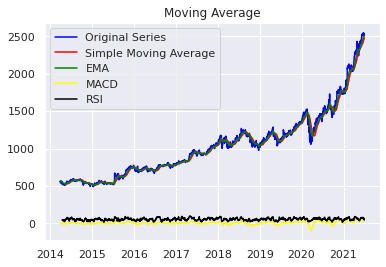

In [36]:
# Plot Moving average:
orig = plt.plot(df_EMA['Close'], color='blue',label='Original Series')
SMA = plt.plot(df_EMA['SMA'], color='red', label='Simple Moving Average')
EMA = plt.plot(df_EMA['EMA'], color='green', label='EMA')
MACD = plt.plot(df_EMA['MACD'], color='yellow', label='MACD')
RSI = plt.plot(df_EMA['RSI'], color='black', label='RSI')
plt.legend(loc='best')
plt.title('Moving Average')
plt.show(block=False)

# PREDICTIONS


In [60]:
#Remove the first 29 days of data
df_EMA = df_EMA[29:]
#Show the data set
df_EMA

,Open,High,Low,Close,Adj Close,Volume,MACD,Signal_Line,up,down,RSI,SMA,EMA,Target
Date,,,,,,,,,,,,,,
2014-05-08,507.067841,515.813843,505.063354,509.600891,509.600891,2021334,-9.107210,-8.055490,1.037140,0.000000,32.564614,536.500707,526.898734,1
2014-05-09,509.351562,518.476501,502.819519,517.309753,517.309753,2439479,-8.746404,-8.193673,7.708862,0.000000,43.153824,535.180000,525.985498,1
2014-05-12,522.076660,528.738342,517.588989,528.469116,528.469116,1912536,-7.473842,-8.049707,11.159363,0.000000,46.834151,534.180411,526.222033,1
2014-05-13,529.436462,534.602234,528.060181,531.630432,531.630432,1653427,-6.139463,-7.667658,3.161316,0.000000,54.239633,533.386592,526.737118,0
2014-05-14,531.540649,531.540649,523.851746,525.208069,525.208069,1191763,-5.536369,-7.241400,0.000000,-6.422363,50.965177,532.039957,526.591495,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-25,2539.139893,2550.100098,2528.879883,2539.899902,2539.899902,1674200,45.126803,47.284471,0.000000,-5.739990,70.444798,2449.394336,2492.146946,0
2021-06-28,2540.000000,2546.739990,2519.476074,2536.389893,2536.389893,1405500,43.257796,46.479136,0.000000,-3.510010,66.004960,2456.735335,2496.360560,0
2021-06-29,2535.449951,2540.000000,2508.739990,2520.370117,2520.370117,1047500,40.022578,45.187824,0.000000,-16.019775,58.289995,2463.367342,2498.647184,0


In [61]:
#Split the data set into a feature or independent data set (X) and a target or dependent data set (Y)
keep_columns = ['Close', 'MACD', 'Signal_Line', 'RSI', 'SMA', 'EMA']
X = df_EMA[keep_columns].values
Y = df_EMA['Target'].values

In [52]:
df_EMA

,Open,High,Low,Close,Adj Close,Volume,MACD,Signal_Line,up,down,RSI,SMA,EMA,Target
Date,,,,,,,,,,,,,,
2014-05-08,507.067841,515.813843,505.063354,509.600891,509.600891,2021334,-9.107210,-8.055490,1.037140,0.000000,32.564614,536.500707,526.898734,1
2014-05-09,509.351562,518.476501,502.819519,517.309753,517.309753,2439479,-8.746404,-8.193673,7.708862,0.000000,43.153824,535.180000,525.985498,1
2014-05-12,522.076660,528.738342,517.588989,528.469116,528.469116,1912536,-7.473842,-8.049707,11.159363,0.000000,46.834151,534.180411,526.222033,1
2014-05-13,529.436462,534.602234,528.060181,531.630432,531.630432,1653427,-6.139463,-7.667658,3.161316,0.000000,54.239633,533.386592,526.737118,0
2014-05-14,531.540649,531.540649,523.851746,525.208069,525.208069,1191763,-5.536369,-7.241400,0.000000,-6.422363,50.965177,532.039957,526.591495,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-25,2539.139893,2550.100098,2528.879883,2539.899902,2539.899902,1674200,45.126803,47.284471,0.000000,-5.739990,70.444798,2449.394336,2492.146946,0
2021-06-28,2540.000000,2546.739990,2519.476074,2536.389893,2536.389893,1405500,43.257796,46.479136,0.000000,-3.510010,66.004960,2456.735335,2496.360560,0
2021-06-29,2535.449951,2540.000000,2508.739990,2520.370117,2520.370117,1047500,40.022578,45.187824,0.000000,-16.019775,58.289995,2463.367342,2498.647184,0


In [62]:
#Split the data again but this time into 80% training and 20% testing data sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

Tạo và đào tạo mô hình.

In [63]:
#Create and train the model 
tree = DecisionTreeClassifier().fit(X_train, Y_train)


In [64]:
#Check how well the SVC Model on training data
print(tree.score(X_train, Y_train))



1.0


In [44]:
#Check the SVC Model on the test data set
print(tree.score(X_test, Y_test))


0.5263157894736842


In [65]:
#show the model tree predictions
tree_predictions = tree.predict(X_test)

print(tree_predictions)


[0 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1
 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0
 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1
 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0
 1 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1
 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0
 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0
 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0
 0 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0
 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0]


In [67]:
tree_predictions.shape

(361,)

In [66]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, tree_predictions))

              precision    recall  f1-score   support

           0       0.58      0.53      0.55       177
           1       0.58      0.62      0.60       184

    accuracy                           0.58       361
   macro avg       0.58      0.58      0.58       361
weighted avg       0.58      0.58      0.58       361



linear regrestion



In [72]:
dataGOOG

,Open,High,Low,Close,Adj Close,Volume,Target
Date,,,,,,,
2014-03-27,566.444824,566.444824,551.406128,556.930969,556.930969,13136,1
2014-03-28,559.663452,564.879150,557.140381,558.456787,558.456787,41213,0
2014-03-31,565.337891,565.447571,555.405151,555.445007,555.445007,10830,1
2014-04-01,557.180237,566.893616,557.180237,565.607117,565.607117,7922,0
2014-04-02,598.347229,603.174011,560.650757,565.447571,565.447571,147103,1
...,...,...,...,...,...,...,...
2021-06-25,2539.139893,2550.100098,2528.879883,2539.899902,2539.899902,1674200,0
2021-06-28,2540.000000,2546.739990,2519.476074,2536.389893,2536.389893,1405500,0
2021-06-29,2535.449951,2540.000000,2508.739990,2520.370117,2520.370117,1047500,0


In [73]:
#Split the data set into a feature or independent data set (X) and a target or dependent data set (Y)
dataGOOG['Target'] = np.where(dataGOOG['Close'].shift(-1) > dataGOOG['Close'], 1, 0) # if tomorrows price is greater than todays price put 1 else put 0
keep_columns = ['Close', 'Open']
X = dataGOOG[keep_columns].values
#X = dataGOOG['Close'].values
#X.reshape(1,-1)

In [74]:
Y = dataGOOG['Target'].values
#Y.reshape(1,-1)

In [75]:
#Split the data again but this time into 80% training and 20% testing data sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [45]:
reg = LinearRegression().fit(X_train, Y_train)

In [47]:
reg_predictions = reg.predict(X_test)

In [69]:
#df_EMA['Target'] = np.where(df_EMA['Close'].shift(-1) > df_EMA['Close'], 1, 0) # if tomorrows price is greater than todays price put 1 else put 0
reg_predictions = np.where(reg_predictions >0.5,1,0 )
reg_predictions

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,

In [76]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, reg_predictions))

              precision    recall  f1-score   support

           0       0.43      0.11      0.18       174
           1       0.52      0.86      0.65       192

    accuracy                           0.51       366
   macro avg       0.48      0.49      0.42       366
weighted avg       0.48      0.51      0.43       366

